In [3]:
import os
ROOT = "/content/drive/MyDrive/bert_topic_modelling"
%cd $ROOT

/content/drive/MyDrive/bert_topic_modelling


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pwd

'/content/drive/My Drive/bert_topic_modelling'

In [6]:
#!wget https://zenodo.org/records/1000885/files/steam.csv.bz2?download=1

In [7]:
#!bzip2 -d /content/drive/MyDrive/bert_topic_modelling/steam.csv.bz2


In [14]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=8e966a049c865f5f6cbd9da50054280be8a5fe183a29357c562bfbb392f11a7e
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [15]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039286 sha256=c70ce16f91f6988421a2af8cacc5294c272b0ba719129706d478bab33cde8128
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [16]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=011cd2ac7bf1c491a304508cc1e96f790638b5d0ed8e1123950d0645761a0863
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [17]:
import numpy as np
import pandas as pd
import random as rn
import re
import nltk
import os

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from nltk.corpus import stopwords
from wordcloud import WordCloud

import umap # dimensionality reduction
import hdbscan # clustering
from functools import partial


from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [18]:
rn.seed(a=42)

p = 0.004  # to randomly select 0.4% of the rows

df_reviews = pd.read_csv('/content/drive/MyDrive/bert_topic_modelling/steam.csv', skiprows=lambda i: i>0 and rn.random() > p)

# size of dataframe
print(df_reviews.shape)
# display the head of data
display(df_reviews.head())

(25435, 4)


,10,Ruined my life.,1,0
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


In [21]:
df_reviews.columns

Index(['app_id', 'review_text', 'review_score', 'review_votes'], dtype='object')

In [22]:
df_reviews.columns = ['app_id', 'review_text', 'review_score', 'review_votes']

In [23]:
df_reviews.head(5)

,app_id,review_text,review_score,review_votes
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


<Axes: xlabel='review_score', ylabel='count'>

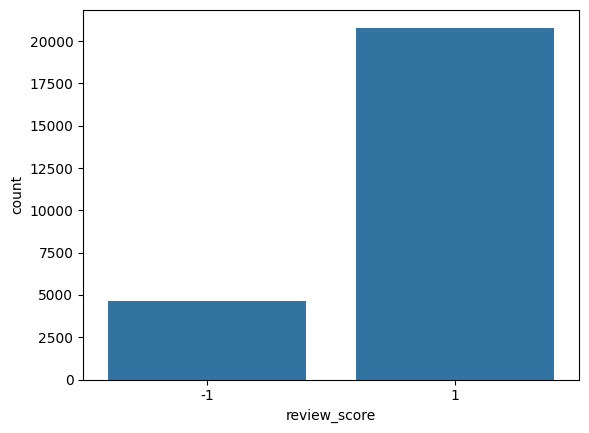

In [24]:

sns.countplot(x = 'review_score', data = df_reviews)

In [25]:
df_reviews['review_text'] = df_reviews['review_text'].astype(str)
df_reviews['review_votes'] = df_reviews['review_votes'].astype(str)

df_reviews.review_text = df_reviews.review_text.apply(lambda s : s.strip())

df_reviews_2 = df_reviews[df_reviews['review_score'].notnull()]

df_reviews_2['review_score'] = np.where(df_reviews_2['review_score'] == -1, 0, df_reviews_2['review_score'])

df_reviews_2.head()

,app_id,review_text,review_score,review_votes
0,10,Think you got skills because you came from CS:GO? Think you got skills cause you came from COD? Think you got skills cause you just bought fallout 4 and still got money left on your steam account? Well let me tell you a story. You're going to suck ♥♥♥. Alot of ♥♥♥.,1,1
1,10,"(I've deleted all the comments on this because I wanted to give a serious review about this game and delete my older one, so here ya go) This is the older Counter-Strike as most people know it. Some people usually don't find enjoyment in playing it due to it being either 'out-dated' or 'glitchy'. I personally tend to enjoy this game from time to time because it's an original game made from th...",1,0
2,10,Game will be played forever,1,0
3,10,i can't stop playing :D,1,0
4,10,Good The best game,1,0


In [26]:
df_reviews_2["review_score"] == 1

0         True
1         True
2         True
3         True
4         True
         ...  
25430     True
25431     True
25432     True
25433    False
25434    False
Name: review_score, Length: 25435, dtype: bool

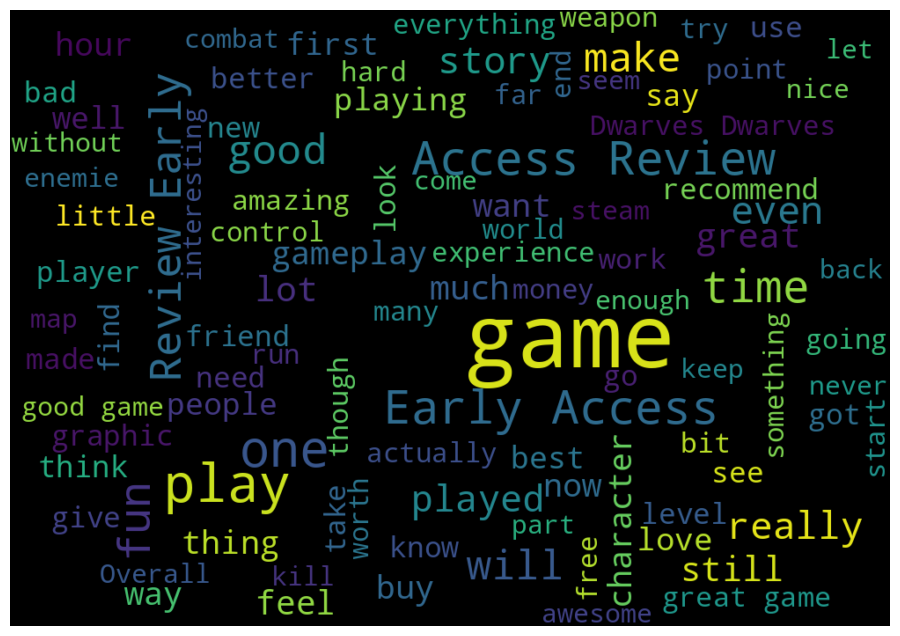

In [27]:
txt = ' '.join(rev for rev in df_reviews_2.review_text )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100,
    width=1000,
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

In [28]:
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != 'Early Access Review']

df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]



df_reviews_2.drop_duplicates(['review_text', 'review_score' ], inplace = True )

print(df_reviews_2.shape)

(21178, 4)


In [29]:
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)

###Function To remove Emoji

In [30]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

##Clean Some Basic Characters

In [31]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

##Remove numeric

In [32]:
def remove_num(texts):
    output = re.sub(r'\d+', '', texts )
    return output

##function to unify whitespaces

In [33]:
def unify_whitespaces(text):
  cleaned_string = re.sub(" +"," ",text)
  return cleaned_string


##function to remove punctuation

In [34]:
def remove_punctuation(text):
  result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
  return result

##remove stopwords

In [35]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

nltk.download('stopwords')

from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

def remove_stopwords(text):
  text = [word.lower() for word in text.split() if word.lower() not in stop]
  return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##function to use stemming to normalize words

In [36]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')

def Stemming(text):
  stem  = []
  stopword = stopwords.words('english')
  snowball_stemmer = SnowballStemmer('english')
  word_tokens = nltk.word_tokenize(text)
  stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
  stem = ' '.join(stemmed_word)
  return stem

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Aplying all the cleaning util methods

In [37]:
def cleaning(df,review):
  df_processed = df.copy()
  df_processed[review] = df_processed['review_text']
  df_processed[review] = df_processed[review].apply(clean)
  df_processed[review] = df_processed[review].apply(deEmojify)
  df_processed[review] = df_processed[review].apply(replace_hearts_with_PAD)
  df_processed[review] = df_processed[review].apply(remove_num)
  df_processed[review] = df_processed[review].apply(remove_punctuation)
  df_processed[review] = df_processed[review].apply(remove_stopwords)
  df_processed[review] = df_processed[review].apply(unify_whitespaces)
  df_processed[review] = df_processed[review].apply(Stemming)
  return df_processed


df_processed = cleaning(df_reviews_2,"review_text_clean")




In [38]:
neg_reviews = df_processed[df_processed["review_score"] == 0]
neg_reviews = neg_reviews.sample(2000,random_state = 1234)

all_intents = neg_reviews.review_text_clean.tolist()

print(neg_reviews.shape)



(2000, 5)


In [39]:

neg_reviews.head()


,app_id,review_text,review_score,review_votes,review_text_clean
4382,218620,"I used to love playing this game for its fantastic co-op, pefect for getting couple of friends and having a good time. But with the microtransactions? Seriously Overkill? Way to kill your modding community. This isn't CS:GO.",0,0,use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo
23346,50300,"If you want to play the game on easy difficulty than do it, it's probably good. I tried playing it on hard difficulty and it just turns out to be impossible. Apart from the stupidly tedious controls and all but responsive animations( i.e. your character will get stuck between objects, will have an incredibly hard time deciding whether to go out of cover or reload, glitching out really bad, and...",0,0,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ( ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight ) let finish game stun stupid suicid ai teammat anyth help time they ll go enemi fire die like * * * * es tri get better cover they ll keep shoot wa...
2312,204060,Bad game. Not worth any money.,0,0,bad game worth money
23458,51100,this is my first ever game on steam i have masterd quick scoping and what the ♥♥♥♥! they removed snipers how could they is this a glitch or a mistake if its gone this game is broken,0,0,first ever game steam masterd quick scope * * * * remov sniper could glitch mistak gone game broken
24869,7770,"This game is one of the worst X-COM Games ever made. Horrible Graphics. Annoying Voices. Boring. Over Powered weapons can be unlocked early in-game, making the game just a matter of paitence. Window 10 user? Won't allow you to see ANYTHING OTHER THAN THE TOP LEFT CORNER. Sure, the types of weapon isn't in any other X-COM game, but then, the game is just plain off a waste of 5 dollars.",0,1,game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar


In [40]:
all_intents

['use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo',
 "want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ( ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight ) let finish game stun stupid suicid ai teammat anyth help time they ll go enemi fire die like * * * * es tri get better cover they ll keep shoot wall complet ignor enemi besid result get knife stab time ca n't trust back enemi come without anyth possibl one worst ai i ve ever seen game heal everi flippin ' second they re dumb know great stori get collect intel listen enemi dialogu enough keep motiv play piec",
 'bad game worth money',
 'first ever game steam masterd quick scope * * * * remov sniper could glitch mistak gone game broken',
 'game one worst x-com game ever made horribl graphic annoy voic bore power w

In [41]:
all_sents = []


for intent in all_intents:
  for sent in nltk.sent_tokenize(intent):
    if len(sent.split()) > 4:
      all_sents.append(sent)


print(len(all_sents))

all_intent = all_sents

1793


In [42]:
all_intent[3]

'game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar'

In [43]:
nltk.sent_tokenize(all_intent[3])

['game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar']

In [44]:
nltk.tokenize.sent_tokenize(all_intent[3], language='english')


['game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar']

In [46]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.6 MB/s eta 0:00:00


##Sentence Embedding

In [50]:
from sentence_transformers import SentenceTransformer
import tensorflow as tf

In [51]:
def embed(model,model_type,sentences):
  if model_type == 'use':
    embeddings = model(sentences)
  elif model_type == 'sentence transformer':
    embeddings = model.encode(sentences)
  return embeddings

In [54]:
model_st1 = SentenceTransformer('all-mpnet-base-v2', device='cpu')

embeddings_st1 = embed(model_st1,'sentence transformer',all_intents)


In [ ]:
#embeddings_st1[0]

In [55]:
!pip install hdbscan

In [56]:
#!pip uninstall umap
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=438dd25b6954a54352db061892666298c44d0bff12591dcff913578be60ae57d
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


##Dimensionality Reduction

In [57]:
#import umap
import umap.umap_ as umap
import hdbscan
from functools import partial


from hyperopt import fmin,tpe,hp,STATUS_OK,space_eval,Trials

In [58]:
def generate_clusters(message_embeddings,n_neighbors,n_components,min_cluster_size,min_samples = None,random_state = None):
  umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,n_components = n_components, metric = 'cosine',random_state = random_state).fit_transform(message_embeddings))

  clusters = hdbscan.HDBSCAN(min_cluster_size= min_cluster_size,min_samples =min_samples, metric = 'euclidean',gen_min_span_tree=True,cluster_selection_method='eom').fit(umap_embeddings)

  return clusters

##Use Bayesian Optimization with Hyperopt

In [59]:
def score_clusters(clusters, prob_threshold=0.05):
    """
    Score the clusters based on their labels and probabilities.

    Args:
        clusters (hdbscan.HDBSCAN): Clustering model.
        prob_threshold (float, optional): Probability threshold for considering a sample as an outlier.
            Default is 0.05.

    Returns:
        int: Number of unique cluster labels.
        float: Cost score representing the fraction of samples with probabilities below the threshold.

    """
    cluster_labels = clusters.labels_

    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)

    cost = np.count_nonzero(clusters.probabilities_ < prob_threshold) / total_num

    return label_count, cost





def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperparameter optimization.

    Args:
        params (dict): Dictionary of hyperparameters.
        embeddings (np.ndarray): Array of message embeddings.
        label_lower (int): Lower bound for the number of unique cluster labels.
        label_upper (int): Upper bound for the number of unique cluster labels.

    Returns:
        dict: Dictionary containing the loss value, number of unique cluster labels, and status.

    """
    clusters = generate_clusters(
        embeddings,
        n_neighbors=params["n_neighbors"],
        n_components=params["n_components"],
        min_cluster_size=params["min_cluster_size"],
        random_state=params["random_state"],
    )

    label_count, cost = score_clusters(clusters, prob_threshold=0.05)

    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 1.0
    else:
        penalty = 0

    loss = cost + penalty

    return {"loss": loss, "label_count": label_count, "status": STATUS_OK}






def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

    """

    trials = Trials()
    fmin_objective = partial(
        objective,
        embeddings=embeddings,
        label_lower=label_lower,
        label_upper=label_upper,
    )

    best = fmin(
        fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )

    best_params = space_eval(space, best)
    print("best:")
    print(best_params)
    print(f"label count: {trials.best_trial['result']['label_count']}")

    best_clusters = generate_clusters(
        embeddings,
        n_neighbors=best_params["n_neighbors"],
        n_components=best_params["n_components"],
        min_cluster_size=best_params["min_cluster_size"],
        random_state=best_params["random_state"],
    )

    return best_params, best_clusters, trials












In [60]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,32)),
    "n_components": hp.choice('n_components', range(3,32)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,32)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 25

In [61]:
%%time

best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_st1,
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  4%|▍         | 1/25 [00:14<05:50, 14.62s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  8%|▊         | 2/25 [00:20<03:40,  9.60s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 12%|█▏        | 3/25 [00:28<03:14,  8.82s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 16%|█▌        | 4/25 [00:35<02:49,  8.07s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 20%|██        | 5/25 [00:42<02:33,  7.68s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 24%|██▍       | 6/25 [00:51<02:37,  8.28s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 28%|██▊       | 7/25 [00:58<02:19,  7.75s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 32%|███▏      | 8/25 [01:05<02:08,  7.55s/trial, best loss: 1.2085]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 36%|███▌      | 9/25 [01:13<02:01,  7.58s/trial, best loss: 0.5145]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 40%|████      | 10/25 [01:22<01:58,  7.91s/trial, best loss: 0.51] 

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 44%|████▍     | 11/25 [01:32<02:00,  8.63s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 48%|████▊     | 12/25 [01:39<01:47,  8.28s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 52%|█████▏    | 13/25 [01:48<01:41,  8.48s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 56%|█████▌    | 14/25 [01:55<01:26,  7.84s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 60%|██████    | 15/25 [02:00<01:11,  7.11s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 64%|██████▍   | 16/25 [02:07<01:04,  7.17s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 68%|██████▊   | 17/25 [02:16<01:01,  7.69s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 72%|███████▏  | 18/25 [02:26<00:58,  8.41s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 76%|███████▌  | 19/25 [02:33<00:47,  7.86s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 80%|████████  | 20/25 [02:40<00:38,  7.68s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 84%|████████▍ | 21/25 [02:47<00:30,  7.54s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 88%|████████▊ | 22/25 [02:56<00:23,  7.91s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 92%|█████████▏| 23/25 [03:04<00:16,  8.02s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 96%|█████████▌| 24/25 [03:11<00:07,  7.65s/trial, best loss: 0.51]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



100%|██████████| 25/25 [03:18<00:00,  7.92s/trial, best loss: 0.51]
best:
{'min_cluster_size': 8, 'n_components': 23, 'n_neighbors': 27, 'random_state': 42}
label count: 27


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: user 3min 30s, sys: 3.22 s, total: 3min 33s
Wall time: 3min 28s


In [64]:
c_ = 6

for index,clust in enumerate(best_clusters_use.labels_):
  #print(index)
  if clust == c_:
    print(all_intent[index])


strip anno rip could interest balanc proper featur ad pros much con success heavili weight toward type map good allow trade graphic suck sound suck ca n't name town yet get map river necessari certain industri essenti anno rip except suckier
sucj crapiest grafic world littl effort game
bought game download delet steam cant get back
nope game mani promis none fulfil current gameplay offer hour gameplay reach full insert repeat te idea interest concept cool project abandon left bare playabl state ground work real finish content progress
broken port gtx gb ram onlin game lock fps get dip fps even though play offlin ssd game load quick give shaq erni time talk skip automat take awway experi way hear say
dev obvious go solv quit desktop ' issu given month solv issu im go support anymor review negat solv sh * t anyth i 'm sorri irrespons game full bug even alpha label finish game shame -- -- -- -- -- -- -- -- -- -- -- -- - old review game still bug ( like shut nd season ) im sure work around

In [173]:
len(all_intent)

1793

##Automatic cluster labeling

In [67]:
import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [68]:
data_clustered = pd.DataFrame(data = list(zip(all_intents,best_clusters_use.labels_)),columns = ["text","label_st1"])

In [69]:
data_clustered

,text,label_st1
0,use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo,16
1,want play game easi difficulti probabl good tri play hard difficulti turn imposs apart stupid tedious control respons anim ( ie charact get stuck object incred hard time decid whether go cover reload glitch realli bad lot troubl anyth run straight ) let finish game stun stupid suicid ai teammat anyth help time they ll go enemi fire die like * * * * es tri get better cover they ll keep shoot wa...,-1
2,bad game worth money,20
3,first ever game steam masterd quick scope * * * * remov sniper could glitch mistak gone game broken,-1
4,game one worst x-com game ever made horribl graphic annoy voic bore power weapon unlock earli in-gam make game matter paitenc window user allow see anyth top left corner sure type weapon x-com game game plain wast dollar,-1
...,...,...
1995,total ca n't play,-1
1996,honest like put gun togeth disassembl game say oh boy want put togeth virtual gun ',2
1997,free flash game internet higher qualiti,4
1998,got seri fm love addict fell seri fm hate seri fm hundr hour three various club countri etc graphical/ui updat got better everi year match engin got much wors hope thing would chang fm gave everi chanc februari let go give franchis shame,-1


In [75]:
len(data_clustered["label_st1"].unique().tolist())

27

In [78]:
example = data_clustered[data_clustered["label_st1"] == 16].reset_index(drop = True)
example

,text,label_st1
0,use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo,16
1,pad pay-to-win idl game right mobil port textbook,16
2,idea game tri find hidden treasur vault somewher larg trick make work hard money thus realiz trueli jouney matter destin complic way say grind noth thirti hour * * * * ing sucker,16
3,cdn $ that 's lot money suicid thought serious though game like equival wheel misfortun join game server spin wheel see they ll give get awesom prize semi-dec nice game common prize play -+ ping peopl match ' skill level join game teammat play like limb join game physic get turn hell break loos time rng god come butt * * * * team give team free unstopp goal say hour record howev play lot xbox ...,16
4,cheat promis jackpot never hit baselin push player buy real money edit went loge mani account onlin version check spin play tri bigger spin -k k tabl didnt expect million alway lowest spin rig worst k spin win buy click blind first - time play -k even best card dealt way win unless higher player tabl stupid thing develop amaz game greed ruin let free player equal chanc,16
5,use like game wow trion well let say get class pay buyinh market crazi amount use make game money could pay class ( note cheap still way obtain ) want behind pay wall whatev ill vote chang back,16
6,use good lie start declin downhil see come back chang money system care put skin game thing promis long long time ago realli money chang screw loyal player play i 'd held buy steam version knew i 'd get great stuff instead would got simpli buy point game develop blind stupid greed suppos could expect thank kill great game,16
7,start play game sep pay $ get orb sinc love game decid least support game real money dev give free orb player start play sepin word older player market guy cg compani would kick his/her * * * * fire him/her direct,16
8,fun game bad busi model need pay € hero ( which don ` t care long abl unlock reason fast ) rank loot open ( if want open one everi day ) shame actual realli like mechan i 'm go invest time game need pay much access rank,16
9,last updat decemb use play game lot thing got glitchi realiz much pay-to-win aspect realli saw saw balrog-xi perman cash item knew someth right hour pour fp game kept ad cash item like cso cso ( mind cso look great live korea ) get tri i ve seen mani fp 's turn pw model,16


##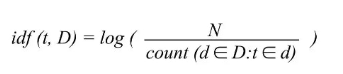Find the IDF (inverse document frequency) of every word  Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where t is the term (word) we are looking to measure the commonness of and N is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, t, appears in.

In [92]:
from collections import Counter

sent_with_word_lemma = []

for intent in all_intents:
  doc = nlp(intent)
  #print(f"intent:{intent}")
  #print(f"doc:{doc} ")
  temp_sentence = ""
  this_one = False
  for token in doc:
    if (token.pos_ in ["VERB","NOUN","ADJ"] or [token.dep_ == "dobj"]):
      temp_sentence += token.lemma_.lower() + " "
  sent_with_word_lemma.append(temp_sentence)


In [93]:
len(sent_with_word_lemma)

2000

In [90]:
#doc = nlp("those couple indulge in love are pretty happy")

#for token in doc:
  #print(token.text,token.dep_,token.lemma_)

In [94]:
sent_with_word_lemma[0]

'use love play game fantast co - op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo '

In [103]:
def compute_IDF(documents):
  word_count = Counter()
  for doc in documents:
    if 'drops(players' in doc:
      print(doc)
    word_set = set(doc.split())
    word_count.update(word_set)
  print(word_count)

  total = sum(word_count.values())
  #print(total)
  word_IDF = {k: round((np.log2(total/v))) for k , v in word_count.items()}
  return word_IDF


In [104]:
word_IDF = compute_IDF(sent_with_word_lemma)

Counter({'game': 1408, 'play': 718, 'get': 616, 'not': 535, 'like': 506, 'even': 416, 'time': 399, '-': 397, "'": 397, 'good': 392, 'make': 392, '(': 364, 'i': 354, 'can': 350, ')': 346, 'would': 344, 'buy': 342, 'realli': 338, 'one': 336, 'well': 325, 'bad': 315, '*': 308, '/': 294, 'go': 291, 'much': 267, 'fun': 267, 'say': 253, 'want': 248, 'tri': 240, 'money': 228, 'do': 228, 'thing': 225, 'feel': 222, 'first': 221, 'hour': 220, 'look': 216, 'see': 212, 'be': 212, 'way': 209, 'recommend': 205, 'think': 203, 'still': 200, 'work': 199, 'm': 196, 'could': 194, 'use': 193, 'give': 186, 'also': 184, 'start': 179, 'take': 176, 'graphic': 175, 'stori': 174, 'run': 172, 'find': 171, 'control': 170, 'great': 168, 'know': 162, "'s": 161, 'new': 160, 'worth': 158, 'everi': 157, 'bore': 155, 'peopl': 155, 'gameplay': 155, 'pretti': 149, 'end': 147, 'actual': 147, 'pay': 147, 'complet': 145, 'back': 145, 'review': 144, 'fix': 142, 'need': 138, 'come': 137, 'someth': 137, 'that': 136, 'hard': 13

###Automatic cluster labeling   ----  Here we’ll concatenate the most common verb, direct object, and top two nouns from each cluster for our Automatic cluster labeling.

In [106]:
def get_group(df,category_col,category):
  single_category = df[df[category_col] == category].reset_index(drop = True)
  return single_category


def most_common(lst,n_words):
  counter = collections.Counter(lst)
  for k in list(counter):
    if counter[k] == 1:
      pass
    else:
      counter[k] *= word_IDF[k]

  return counter.most_common(n_words)

In [117]:
def extract_labels(category_doc, print_word_counts = False):
    '''
    Argument:
        category_docs: list of documents, all from the same category or clustering. category_docs is a list of strings like below
        ['fun game small amount time unless lifer..........', ....  'steem pile graphic' ]

        print_word_counts: bool, True will print word counts of each type in this category
    '''

    verbs = []
    dobjs = []
    nouns = []
    adjs = []

    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    for i in range(len(category_doc)):
        doc = nlp(category_doc[i])
        for token in doc:
            if (token.is_stop == False ) and (len(str(token).strip()) >0 ):
                if token.pos_ == 'VERB':
                    verbs.extend([token.lemma_.lower()])

                elif token.dep_ == 'dobj':
                    dobjs.extend([token.lemma_.lower()])

                elif token.pos_ == 'NOUN':
                    nouns.extend([token.lemma_.lower()])

                elif token.pos_ == 'ADJ':
                    adjs.extend([token.lemma_.lower()])


    # print('most_common(verbs, 1) ', most_common(verbs, 1))
    # [('m', 27)]

    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter = collections.Counter(word_lst)
            print(counter)

    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]

    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]

    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]

    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]


    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]

    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)

    if '' in label_words:
        label_words.remove('')

    label = '_'.join(label_words)

    return label

In [118]:
all_intents[0]

'use love play game fantast co-op pefect get coupl friend good time microtransact serious overkil way kill mod communiti csgo'

In [119]:
current_cat = ['fun game small amount time unless lifer mean insult anyon peopl time other like anyon job kid liter anyth play video game time game made mistak play way mani hour never get past week game explain noth start understand go read watch guid even could random bad luck like spawn world row rain none stop froze death spawn summer die heat within minut game even tell take damag read guid hey im glad peopl like game unless consid hardcor gamer would avoid time sink', 'game look nice slow pace even adventur', 'good remak sound still origin half life rework sourc minus excel graphic sourc im say game bad say inferior origin that avail steam reason say unlik half life half life sourc includ hd mode hd mode basic origin hd pack includ releas blueshift made npcs weapon look consider better real advantag half life sourc origin stabl engin say there anyth wrong gold sourc engin get rid glitch origin end half life sourc realli isnt much improv origin half life improv ps actual think graphic blurri person opinion', 'game interest tower defens mechan primit bore gameplay cool theme', 'want zombi surviv game buy dayz', 'full twelv year old spammer time waister cours drop out start game like game alot player immposs get game togeth without spam cuss leav game report noth develop joke want money take action keep claim im fed crap someth game hard find decent game good develop priceybut get pay ehh', 'find wait line forev join battl rare final get spot join battl actual pretti fun good game play want give wait forev', 'gta iv fantast game stori onlin great reconmen game issu run modern hardwar window run window might alright might issu', 'steem pile graphic' ]


x = extract_labels(current_cat)

In [120]:
x

'want_sourc_game_life'

In [125]:
list(get_group(data_clustered,'label_st1',18)["text"])

["bought download game notic dlc 's includ edit download",
 'dismal vile develop break game content + unit sell time noth sensibl pump money',
 'releas dlc dont * * * * ing care releas * * * * ing mous fix',
 "tldr * * * * overkil usual play payday religi month time take break month rins repeat ive sinc came time start complet lost interest ive bought everi singl piec dlc releas ( onli sale even without microtransact * * * * still thought game money hungri cash cow ) ahv offici lost custom implement microtransact $ base valu $ dlc list absolut atroci start * * * * alreadi exist dlc system mani dlc came becom vital gameplay experi without game honest feel realli stale cant help think intend therefor near mandatori player put extra ~ $ dollar get full game experi ( most dlc actual useless sinc alot new weapon releas still suboptim base game 's weapon also put near valu mask ~ $ dollar get u sniper pack gage courier mod mayb gage weapon pack basic full experi ) introduct sniper rifl let f

In [128]:
def apply_and_summarize_labels(df,category_col):

  numerical_labels = df[category_col].unique()


  label_dict = {}

  for label in numerical_labels:
    current_category = list(get_group(data_clustered,category_col,label)["text"])


    label_dict[label] = extract_labels(current_category)


  summary_df = (df.groupby (category_col)['text'].count()
                .reset_index()
                .rename(columns = {"text" : "count"})
                .sort_values('count',ascending = False)
                )

  summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]],axis = 1)

  return summary_df











In [129]:
cluster_summary = apply_and_summarize_labels(data_clustered,'label_st1')
cluster_summary

,label_st1,count,label
0,-1,1020,play_game_time
15,14,287,play_game_crash
25,24,265,feel_game_time
11,10,47,suck_game_crap
21,20,45,pay_price_game
8,7,26,play_game_pretenti
13,12,24,run_bore_fun_game
5,4,24,play_game_howev
9,8,20,play_game_server
24,23,19,play_game_screen
